#### Master Thesis 2024 - Diksha Acharya

# 2 - Heat index calculation 3h and daily
## Master Thesis 2024
---

2.1 - Imports and tables

In [7]:
# Import 
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import os
from shapely.geometry import Point
from matplotlib.colors import ListedColormap, BoundaryNorm


In [24]:
# Clear all xarray Datasets from memory to free up space
for var_name in list(globals()):
    var = globals()[var_name]
    if isinstance(var, xr.Dataset):
        var.close()
        del globals()[var_name]

In [3]:
# Indian states shapefile
shapefile_path = "Indian_States"
Indian_states = gpd.read_file(shapefile_path)

In [ ]:
# T data for India 3h
file_T_3h = "India_T_3h_masked_C.nc"
T_3h = xr.open_dataset(file_T_3h)
T_3h

In [ ]:
# RH data for India 3h 
file_RH_3h = "India_RH_3h_masked_100.nc"
RH_3h = xr.open_dataset(file_RH_3h)
RH_3h = RH_3h['r']

---
2.1.1 - Convert Kelvin to Fahrenheit

In [ ]:
# Convert temperature from Celsius to Fahrenheit
T_3h_C_0 = T_3h['t2m'].where(T_3h['t2m'] > 0)
T_Fahrenheit_3h_0 = (T_3h_C_0 * 9/5) + 32

In [ ]:
outputfile_T = "T_Fahrenheit_3h_HI_0.nc"
T_Fahrenheit_3h_0.to_netcdf(outputfile_T)

In [26]:
# T Fahrenheit 3h
file_T_3h_F = "T_Fahrenheit_3h_HI_0.nc"
T_Fahrenheit_3h = xr.open_dataset(file_T_3h_F)
T_Fahrenheit_3h['t2m']

<xarray.DataArray 't2m' (time: 245448, latitude: 124, longitude: 120)>
[3652266240 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1940-01-01 ... 2023-12-31T21:00:00
  * longitude  (longitude) float32 68.0 68.25 68.5 68.75 ... 97.25 97.5 97.75
  * latitude   (latitude) float32 38.0 37.75 37.5 37.25 ... 8.0 7.75 7.5 7.25

---
2.2 - Heat index calculation all values (Rajeevan et al.)


In [ ]:
# Calculate Heat Index 
regression_HI_F_3h_0 = (-42.379
        + 2.04901523 * T_Fahrenheit_3h_0
        + 10.14333127 * RH_3h
        - 0.22475541 * T_Fahrenheit_3h_0 * RH_3h
        - 6.83783 * (10**-3) * T_Fahrenheit_3h_0**2
        - 5.481717 * (10**-2) * RH_3h**2
        + 1.22874 * (10**-3) * T_Fahrenheit_3h_0**2 * RH_3h
        + 8.5282 * (10**-4) * T_Fahrenheit_3h_0 * RH_3h**2
        - 1.99 * (10**-6) * T_Fahrenheit_3h_0**2 * RH_3h**2)

In [ ]:
regression_HI_F_3h_0.name = 'heat_index'

In [ ]:
outputfile1 = "regression_HI_F_3h_0.nc"
regression_HI_F_3h_0.to_netcdf(outputfile1)

In [ ]:
# HI°C 3h file
file_HI = "regression_HI_F_3h_0.nc"
regression_HI_F = xr.open_dataset(file_HI)
regression_HI_F

<xarray.Dataset>
Dimensions:     (time: 245448, longitude: 120, latitude: 124)
Coordinates:
  * time        (time) datetime64[ns] 1940-01-01 ... 2023-12-31T21:00:00
  * longitude   (longitude) float32 68.0 68.25 68.5 68.75 ... 97.25 97.5 97.75
  * latitude    (latitude) float32 38.0 37.75 37.5 37.25 ... 8.0 7.75 7.5 7.25
Data variables:
    heat_index  (time, latitude, longitude) float32 ...

In [ ]:
print(regression_HI_F['heat_index'].max().values)
print(regression_HI_F['heat_index'].min().values)

In [ ]:
# Find the location (time, lat, lon) of the maximum heat index value
max_idx = regression_HI_F['heat_index'].argmax(dim=['time', 'latitude', 'longitude'])

# Get the coordinates of the maximum value
max_time = regression_HI_F['time'][max_idx['time']].values
max_lat = regression_HI_F['latitude'][max_idx['latitude']].values
max_lon = regression_HI_F['longitude'][max_idx['longitude']].values

# Extract the corresponding T and RH values at this location
T_at_max = T_Fahrenheit_3h['t2m'].sel(time=max_time, latitude=max_lat, longitude=max_lon).values
RH_at_max = RH_3h.sel(time=max_time, latitude=max_lat, longitude=max_lon).values

print(f"Max HI at time: {max_time}, lat: {max_lat}, lon: {max_lon}")
print(f"Corresponding T (°F): {T_at_max}")
print(f"Corresponding RH (%): {RH_at_max}")

In [ ]:
heat_index_C_3h = (regression_HI_F - 32) * 5 / 9 

In [ ]:
outputfile2 = "Heat_Index_C_3h_0.nc"
heat_index_C_3h.to_netcdf(outputfile2)

---
2.3 - Apply adjustments (US Department of Commerce, 2024)

In [ ]:
# Calculate adjustments
adjustment_1 = ((13 - RH_3h) / 4) * np.sqrt((17 - abs(T_Fahrenheit_3h - 95)) / 17)
adjustment_2 = ((RH_3h - 85) / 10) * ((87 - T_Fahrenheit_3h) / 5)

In [ ]:
# Save A1 file
outputfile = "adjustment_1_0.nc"
adjustment_1.to_netcdf(outputfile)

In [28]:
# Adjustment 1 file
adjustment_1 = "adjustment_1_0.nc"
adjustment_1 = xr.open_dataset(adjustment_1)
adjustment_1 = adjustment_1['t2m']

In [ ]:
# Save A2 file
outputfile = "adjustment_2_0.nc"
adjustment_2.to_netcdf(outputfile)

In [30]:
# Adjustment 2 file
adjustment_2 = "adjustment_2_0.nc"
adjustment_2 = xr.open_dataset(adjustment_2)
adjustment_2 = adjustment_2['t2m']

In [ ]:
# Create masks for conditions
mask_low_RH = (RH_3h < 13) & (T_Fahrenheit_3h >= 80) & (T_Fahrenheit_3h <= 112)
mask_high_RH = (RH_3h > 85) & (T_Fahrenheit_3h >= 80) & (T_Fahrenheit_3h <= 87)

In [ ]:
# Save mask 1 file
outputfile1 = "mask_low_RH.nc"
mask_low_RH.to_netcdf(outputfile1)

In [31]:
# Mask 1 file
mask_low_RH = "mask_low_RH.nc"
mask_low_RH_1 = xr.open_dataset(mask_low_RH)
mask_low_RH_1 = mask_low_RH_1['t2m']

In [ ]:
# Save mask 2 file
outputfile2 = "mask_high_RH.nc"
mask_high_RH.to_netcdf(outputfile2)

In [32]:
# Mask 2 file
mask_high_RH = "mask_high_RH.nc"
mask_high_RH_2 = xr.open_dataset(mask_high_RH)
mask_high_RH_2 = mask_high_RH_2['t2m']

In [ ]:
# 1. Calculate simple formula first
simple_HI = 0.5 * (T_Fahrenheit_3h + 61.0 + ((T_Fahrenheit_3h - 68.0) * 1.2) + (RH_3h * 0.094))

In [6]:
outputfile_simple_HI = "simple_HI.nc"
simple_HI.to_netcdf(outputfile_simple_HI)

In [33]:
# Simpler HI file
simple_HI = "simple_HI.nc"
simple_HI = xr.open_dataset(simple_HI)
simple_HI = simple_HI['t2m']

In [ ]:
# Average simple HI with temperature
averaged_HI = 0.5 * (simple_HI + T_Fahrenheit_3h)
final_HI = xr.where(averaged_HI >= 80, regression_HI_F['heat_index'], averaged_HI)

In [36]:
final_HI

<xarray.Dataset>
Dimensions:    (time: 245448, latitude: 124, longitude: 120)
Coordinates:
  * time       (time) datetime64[ns] 1940-01-01 ... 2023-12-31T21:00:00
  * longitude  (longitude) float32 68.0 68.25 68.5 68.75 ... 97.25 97.5 97.75
  * latitude   (latitude) float32 38.0 37.75 37.5 37.25 ... 8.0 7.75 7.5 7.25
Data variables:
    t2m        (time, latitude, longitude) float32 nan nan nan ... nan nan nan

In [ ]:
# Apply adjustment 1 
condition1 = averaged_HI >= 80
condition2 = mask_low_RH_1.astype(bool)  # Convert to boolean
final_HI_a1 = xr.where(
    condition1 & condition2,  
    final_HI['t2m'] - adjustment_1, 
    final_HI['t2m']
)

In [ ]:
# Apply adjustment 2
condition3 = mask_high_RH_2.astype(bool)  # Convert to boolean
final_HI_a1_a2 = xr.where(
    condition1 & condition3,  
    final_HI_a1['t2m'] - adjustment_2, 
    final_HI_a1['t2m']
)

In [44]:
outputfile = "Heat_Index_F_final_with_adjustments.nc"
final_HI_a1_a2.to_netcdf(outputfile)

In [45]:
# Adjustment 1 file
HI_F_3h = "Heat_Index_F_final_with_adjustments.nc"
HI_F_3h = xr.open_dataset(HI_F_3h)
HI_F_3h 

<xarray.Dataset>
Dimensions:    (time: 245448, latitude: 124, longitude: 120)
Coordinates:
  * time       (time) datetime64[ns] 1940-01-01 ... 2023-12-31T21:00:00
  * longitude  (longitude) float32 68.0 68.25 68.5 68.75 ... 97.25 97.5 97.75
  * latitude   (latitude) float32 38.0 37.75 37.5 37.25 ... 8.0 7.75 7.5 7.25
Data variables:
    t2m        (time, latitude, longitude) float32 ...

In [46]:
HI_F_3h = HI_F_3h.rename({'t2m': 'heat_index'})

In [ ]:
HI_C_3h = (HI_F_3h - 32) * 5.0 / 9.0
HI_C_3h

<xarray.Dataset>
Dimensions:     (time: 245448, longitude: 120, latitude: 124)
Coordinates:
  * time        (time) datetime64[ns] 1940-01-01 ... 2023-12-31T21:00:00
  * longitude   (longitude) float32 68.0 68.25 68.5 68.75 ... 97.25 97.5 97.75
  * latitude    (latitude) float32 38.0 37.75 37.5 37.25 ... 8.0 7.75 7.5 7.25
Data variables:
    heat_index  (time, latitude, longitude) float32 nan nan nan ... nan nan nan

In [54]:
outputfile = "Heat_Index_C_3h_final_with_adjustments.nc"
HI_C_3h.to_netcdf(outputfile)

In [ ]:
# Adjustment 1 file
HI_C_3h = "Heat_Index_C_3h_final_with_adjustments.nc"
HI_C_3h = xr.open_dataset(HI_C_3h)
HI_C_3h 

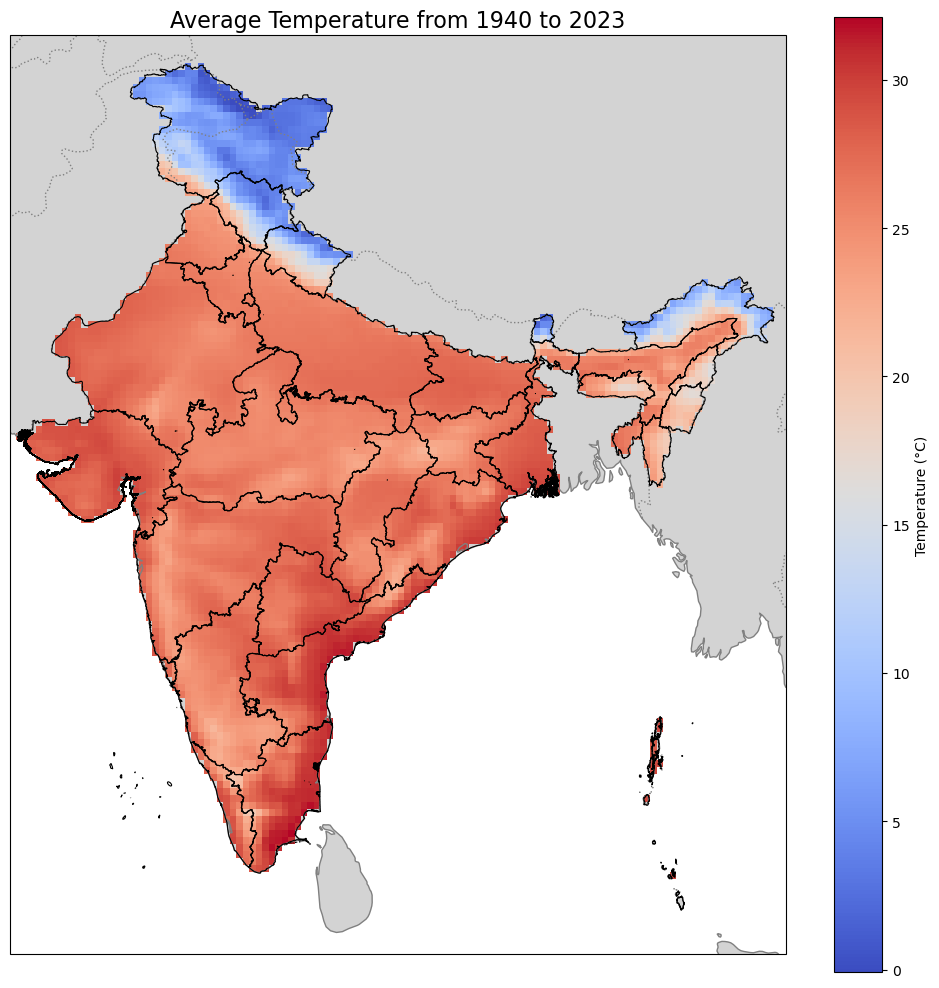

In [55]:
# Plotting the average temperature all on the map of India
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
ax.add_feature(cfeature.COASTLINE, edgecolor='gray')
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Add Indian states boundaries
Indian_states.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)

# Plot the data
img = ax.pcolormesh(HI_C_3h['longitude'], HI_C_3h['latitude'], (HI_C_3h['heat_index']).sel(time=slice('1940-01-01', '2023-12-31')).mean(dim='time'), # year - month - day & mean of this period
                    cmap='coolwarm', transform=ccrs.PlateCarree())
cbar = plt.colorbar(img, ax=ax, label='Temperature (°C)')

# Title and labels
plt.title("Average Temperature from 1940 to 2023", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.tight_layout()
plt.show()

---
2.4 - Verfication of HI values

In [8]:
# Define temperature (descending) and RH (ascending) bins
temp_C = np.array([52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6])
temp_F = (temp_C * 9 / 5) + 32
rhs = np.array([0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100])

In [10]:
# Create meshgrid for all combinations
T_F_grid, RH_grid = np.meshgrid(temp_F, rhs, indexing='ij')

# Apply the Heat Index formula
regression_HI_F_grid = (
    -42.379
    + 2.04901523 * T_F_grid
    + 10.14333127 * RH_grid
    - 0.22475541 * T_F_grid * RH_grid
    - 6.83783e-3 * T_F_grid**2
    - 5.481717e-2 * RH_grid**2
    + 1.22874e-3 * T_F_grid**2 * RH_grid
    + 8.5282e-4 * T_F_grid * RH_grid**2
    - 1.99e-6 * T_F_grid**2 * RH_grid**2
)

In [11]:
# Apply the simple Heat Index formula
simple_HI_grid = 0.5 * (
    T_F_grid + 61.0 + ((T_F_grid - 68.0) * 1.2) + (RH_grid * 0.094)
)

In [12]:
averaged_HI_grid = 0.5 * (simple_HI_grid + T_F_grid)

In [13]:
# Adjustments
adjustment_1_grid = ((13 - RH_grid) / 4) * np.sqrt((17 - abs(T_F_grid - 95)) / 17)
adjustment_2_grid = ((RH_grid - 85) / 10) * ((87 - T_F_grid) / 5)

C:\Users\dacharya\AppData\Local\Temp\ipykernel_23128\940176291.py:2: RuntimeWarning: invalid value encountered in sqrt
  adjustment_1_grid = ((13 - RH_grid) / 4) * np.sqrt((17 - abs(T_F_grid - 95)) / 17)


In [14]:
# Create masks for conditions
mask_low_RH = (RH_grid < 13) & (T_F_grid >= 80) & (T_F_grid <= 112)
mask_high_RH = (RH_grid > 85) & (T_F_grid >= 80) & (T_F_grid <= 87)

In [15]:
regression_HI_F_grid = np.where(averaged_HI_grid < 80, averaged_HI_grid, regression_HI_F_grid)

In [16]:
# Apply adjustments where conditions are met
regression_HI_F_grid = np.where(mask_low_RH, regression_HI_F_grid - adjustment_1_grid, regression_HI_F_grid)
regression_HI_F_grid = np.where(mask_high_RH, regression_HI_F_grid + adjustment_2_grid, regression_HI_F_grid)


In [17]:
regression_HI_C_grid = (regression_HI_F_grid - 32) * 5.0 / 9.0

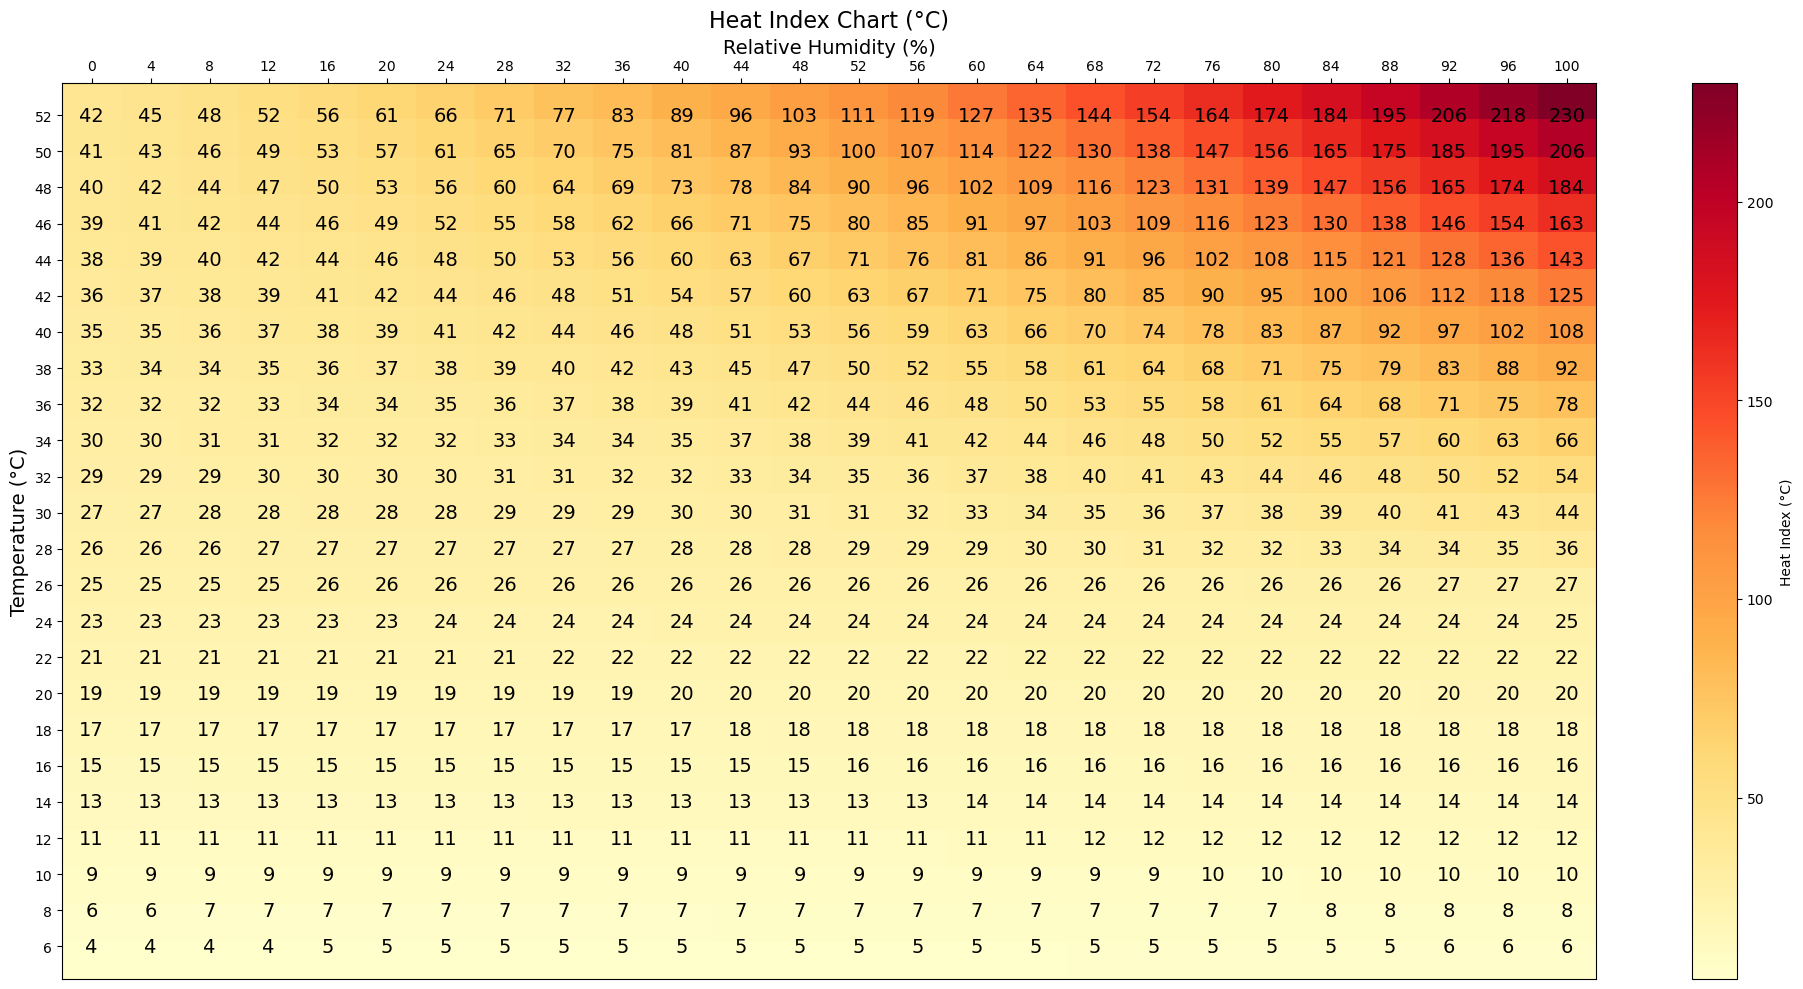

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))

# Prepare data for plotting
# temp_F (y-axis) and rhs (x-axis) are both ascending for imshow
# But temp_F is currently descending, so reverse it for plotting
temp_C_asc = temp_C[::-1]
HI_plot = regression_HI_C_grid[::-1, :]  # Flip rows to match ascending y-axis

# Plot the heatmap
im = ax.imshow(HI_plot, aspect='auto', cmap='YlOrRd',
               extent=[rhs[0] - 2, rhs[-1] + 2, temp_C_asc[0] - 1.8, temp_C_asc[-1] + 1.8],
               origin='lower')

# Annotate each cell with the HI value
for i in range(HI_plot.shape[0]):
    for j in range(HI_plot.shape[1]):
        value = HI_plot[i, j]
        if not np.isnan(value):
            ax.text(rhs[j], temp_C_asc[i], f"{value:.0f}", ha='center', va='center', fontsize=14, color='black')

# Set axis labels and ticks
ax.set_xticks(rhs)
ax.set_yticks(temp_C_asc)
ax.set_xlabel('Relative Humidity (%)', fontsize=14)
ax.set_ylabel('Temperature (°C)', fontsize=14)

# Move x-axis to the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', label='Heat Index (°C)')

plt.title('Heat Index Chart (°C)', fontsize=16, pad=40)
plt.tight_layout()
plt.show()

---
2.5 - HI daily stat 

2.5.1 - HI all daily values 

In [4]:
# table for HI all °C
file_HI_3h = "Heat_Index_C_3h_final_with_adjustments.nc"
HI_3h = xr.open_dataset(file_HI_3h)
HI_3h['heat_index']

<xarray.DataArray 'heat_index' (time: 245448, latitude: 124, longitude: 120)>
[3652266240 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1940-01-01 ... 2023-12-31T21:00:00
  * longitude  (longitude) float32 68.0 68.25 68.5 68.75 ... 97.25 97.5 97.75
  * latitude   (latitude) float32 38.0 37.75 37.5 37.25 ... 8.0 7.75 7.5 7.25

In [5]:
# Compute daily maximum temperature
daily_max = HI_3h['heat_index'].resample(time='1D').max()

# Compute daily minimum temperature
daily_min = HI_3h['heat_index'].resample(time='1D').min()

# Compute daily average temperature
daily_avg = HI_3h['heat_index'].resample(time='1D').mean()

# Combine all three datasets into a new xarray.Dataset
daily_stats = xr.Dataset(
    {
        'daily_max_HI': daily_max,
        'daily_min_HI': daily_min,
        'daily_avg_HI': daily_avg
    }
)

# Save the combined dataset to a new NetCDF file
output_file_1 = "India_HI_adjustment_daily_stats.nc"
daily_stats.to_netcdf(output_file_1)

print(f"Daily maximum, minimum, and average temperatures have been saved to {output_file_1}")


Daily maximum, minimum, and average temperatures have been saved to India_HI_adjustment_daily_stats.nc
